# Urticaria Model v07 // 2023/01/12

## Libraries

In [6]:
import numpy as np
from numpy.linalg import matrix_power
import random as rnd
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import normalize
from scipy.optimize import leastsq, least_squares
import scipy.stats
import time

import sys
!{sys.executable} -m pip install openpyxl

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://git

## States, Rate and Transition Matrix

In [7]:
# read excel in data frame
path = r"20230117_Urticaria Markov Transition Rates_v07.xlsx"
#path = r"C:\Users\gmeinbe3\OneDrive - Novartis Pharma AG\Projects\Data Strategy\05_projects\02_urtikaria\Urticaria Markov\20221125_Urticaria Markov Transition Rates_v06.xlsx"
#assert os.path.isfile(path)
df_rates = pd.read_excel(path, sheet_name='Export_rates') 
df_UCT = pd.read_excel(path, sheet_name='Export_UCT')  
df_diseasestates_input = pd.read_excel(path, sheet_name='Export_statesfitting') 
df_remission = pd.read_excel(path, sheet_name='Export_remission') 

#display(df_rates)
#display(df_UCT)
#display(df_diseasestates_input)

array([[8.83418844e-01, 1.16563962e-01, 1.71935859e-05],
       [5.34231115e-03, 9.55233047e-01, 3.94246422e-02],
       [6.89953442e-03, 7.71157406e-02, 9.15984725e-01]])

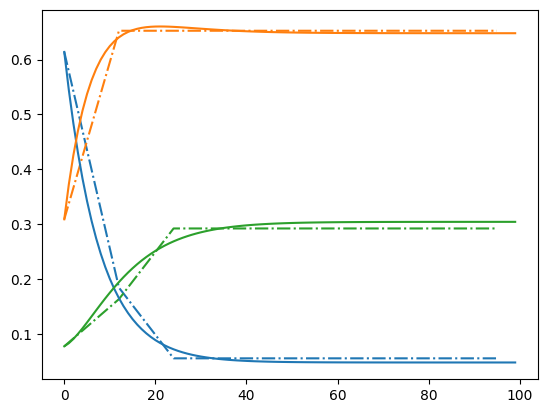

In [8]:
# Fit disease states

t=100
t2=7

states_to_fit = np.zeros([t,3])
t_vec=np.array([5,17,29])
t_vec -= 5
t_vec_new=np.append(t_vec,np.arange((t_vec[-1]+1),t, 10, dtype=int))
states_to_fit[t_vec,:] = ([[0.614, 0.3088, 0.0772], [0.1842, 0.65264, 0.16316], [0.05526, 0.65264, 0.2921]]) # Form:uncontrolled, controlled, symp free at t=5, 17, 29
states_to_fit[t_vec[-1]:,:] = states_to_fit[t_vec[-1],:]

def model_diseasestates(variables):
    #u: uncontrolled;  c: controlled;  s: symptom-free
    uu = variables[0]
    uc = variables[1]
    us = variables[2]
    cu = variables[3]
    cc = variables[4]
    cs = variables[5]
    su = variables[6]
    sc = variables[7]
    ss = variables[8]    
    transMatrix=np.array([[uu, uc, us],
                         [cu, cc, cs],
                         [su, sc, ss]])
    transMatrix_norm=normalize(transMatrix, axis=1, norm='l1')
    #display(transMatrix_norm)

    initialState = np.array([0.614,0.3088,0.0772])   
    timeevol=initialState
    for k in range(1,t):
        timeevol=np.append(timeevol,np.matmul(initialState,matrix_power(transMatrix_norm, k)))
    timeevol=timeevol.reshape((k+1),len(initialState))
    return timeevol

def residual(variables):

    temp=model_diseasestates(variables)
    return (((states_to_fit[t_vec_new[0:t2],:]-temp[t_vec_new[0:t2],:])**2).sum().sum()) 

start_params=[.838,.0162,.00,.009,.904,.087,.009,.192,.799] 


out = least_squares(residual, start_params, bounds=(0,1))
temp=model_diseasestates(out.x)

diseaseprobabilities_fitted=normalize(out.x.reshape(3,3), axis=1, norm='l1')
display(diseaseprobabilities_fitted)

plt.plot(t_vec_new, states_to_fit[t_vec_new,0],'-.',color='C0')
plt.plot(t_vec_new, states_to_fit[t_vec_new,1],'-.',color='C1')
plt.plot(t_vec_new, states_to_fit[t_vec_new,2],'-.',color='C2')
plt.plot(temp[:,0],color='C0')
plt.plot(temp[:,1],color='C1')
plt.plot(temp[:,2],color='C2')

In [9]:
rateMatrix = np.asarray(df_rates)
UCTMatrix = np.asarray(df_UCT)
states = df_rates.columns.values
np.set_printoptions(precision=3, suppress=True)
#print(states)
#print(rateMatrix)
#print(UCTMatrix)

In [10]:
# Define Transition Matrix
time = 1 #time for rateMatrix in weeks
transMatrix=1-np.exp(-rateMatrix/time)
transMatrix[5:8,5:8]=diseaseprobabilities_fitted
for k in range(len(transMatrix)):
    transMatrix[k,k]=0
    transMatrix[k,k]=1-sum(transMatrix[k,:])

for k in range(len(transMatrix)):
    if sum(transMatrix[k])!=1:
        print("Probabilities in row",str(k),"!=1 - Value:", str(sum(transMatrix[k])))
        
print(transMatrix)


[[0.986 0.008 0.002 0.    0.    0.    0.    0.    0.005]
 [0.    0.924 0.    0.049 0.026 0.    0.    0.    0.001]
 [0.    0.    0.999 0.    0.    0.    0.    0.    0.001]
 [0.    0.    0.    0.808 0.    0.116 0.06  0.015 0.001]
 [0.    0.    0.    0.    0.999 0.    0.    0.    0.001]
 [0.    0.    0.    0.    0.    0.882 0.117 0.    0.001]
 [0.    0.    0.    0.    0.    0.005 0.954 0.039 0.001]
 [0.    0.    0.    0.    0.    0.007 0.077 0.915 0.001]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.   ]]


In [11]:
print(states)
np.savetxt("rateMatrix.csv", rateMatrix, delimiter=",")
np.savetxt("transMatrix.csv", transMatrix, delimiter=",")
np.savetxt("states.csv",states,fmt='%s', delimiter=",")

['Symptomatic' 'Diagnosed' 'No_diagnosis_virt' 'Treatment_start'
 'No_treatment_virt' 'Unconrtrolled' 'Controlled' 'Symptom_free'
 'Remission_virt']


In [12]:
display(transMatrix[0:8,8])

array([0.005, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

## Time Evolution and Steady State

In [13]:
remission_prob=np.asarray(df_remission)
display(df_remission.values[121])
transMatrix[0:8,8]=remission_prob[100]
print(transMatrix)

array([0.002])

[[0.986 0.008 0.002 0.    0.    0.    0.    0.    0.002]
 [0.    0.924 0.    0.049 0.026 0.    0.    0.    0.002]
 [0.    0.    0.999 0.    0.    0.    0.    0.    0.002]
 [0.    0.    0.    0.808 0.    0.116 0.06  0.015 0.002]
 [0.    0.    0.    0.    0.999 0.    0.    0.    0.002]
 [0.    0.    0.    0.    0.    0.882 0.117 0.    0.002]
 [0.    0.    0.    0.    0.    0.005 0.954 0.039 0.002]
 [0.    0.    0.    0.    0.    0.007 0.077 0.915 0.002]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.   ]]


In [14]:
def timeseries_prob(transMatrix, x0, timelength):
    n_states=x0.size
    result=np.zeros((timelength,n_states))
    x_k=x0.copy()
    result=np.zeros((timelength,n_states))
    result[0,]=x_k
    for k in range(1,timelength):
        if k<1000:
            transMatrix[0:8,8]=remission_prob[k]
            for m in range(len(transMatrix)):
                transMatrix[m,m]=0
                transMatrix[m,m]=1-sum(transMatrix[m,:])
        x_k=np.dot(x_k,transMatrix)
        result[k,]=x_k
    return result

In [15]:
def timeseries_MC_vec(transMatrix, x0, timelength,n_patients):
    n_states=x0.size
    result_allpat=np.zeros((n_patients, n_states, timelength))
    #nrem=0
    x_k=np.dot(np.ones((n_patients,1)),x0.reshape(1,-1))
    result_allpat[:,:,0] = x_k

    for k in range(timelength):
        if k<1000:
            transMatrix[0:8,8]=remission_prob[k]
            for m in range(len(transMatrix)):
                transMatrix[m,m]=0
                transMatrix[m,m]=1-sum(transMatrix[m,:])
        x_k=np.dot(x_k,transMatrix)
        for l in range(n_patients):
            a=np.random.choice(range(n_states), 1, p=x_k[l,])
            x_k[l,:]=0
            x_k[l,a]=1
        result_allpat[:,:,k] = x_k
    result=result_allpat.sum(axis=0)
    return result.T


In [16]:
# Steady state from Monte Carlo
def steadystate_MC(transMatrix, x0, timelength,n_patients,simulationcycles):
    result=np.zeros(((simulationcycles+1)*timelength,x0.size))
    #t=timeseries_MC_vec(transMatrix, x0, timelength, n_patients)
    t=timeseries_prob(transMatrix, x0, timelength)
    for k in range(0,((simulationcycles)*timelength)):
        result[k:(k+timelength),]+=t
        result[(k+timelength)+1:-1,]+=t[-1,]
        #print(k)
    return result[0:k,], t

In [17]:
# Calculate steady state
def get_steadystate(transMatrix):
    x0 = np.array([1,0,0,0,0,0,0,0,0]) 
    timelength=8000
    n_patients=10
    #n_patients=10
    simulationcycles=2
    [result, t]=steadystate_MC(transMatrix, x0, timelength,n_patients,simulationcycles)
    normvec=np.sum(result,1)
    result_norm=(result)/normvec[:,None]
    result_norm_noremission=result_norm[-1,0:8]/sum(result_norm[-1,0:8])*100
    return result_norm_noremission
    #plt.plot(result_norm[:,1:7])


## Interventions

In [18]:
# diagnosis rate (awareness campaign)
var_diagrate=1.42
transMatrix_awa1=transMatrix.copy()
transMatrix_awa1[0,1]=transMatrix[0,1]*var_diagrate  
transMatrix_awa1[0,2]=transMatrix[0,2]*var_diagrate 

#KOL diagnosis program | 36% higher diagnosis rate 
#display(transMatrix)
var_diagratio=0.36
transMatrix_edu1=transMatrix.copy()
transMatrix_edu1[0,1]=transMatrix[0,1]+transMatrix[0,2]*var_diagratio
transMatrix_edu1[0,2]=transMatrix[0,2]-transMatrix[0,2]*var_diagratio 

# treatment ratio (DMP)
var_treatmentratio=0.18
transMatrix_dmp1=transMatrix.copy()
transMatrix_dmp1[1,3]=transMatrix[1,3]+transMatrix[1,3]*var_treatmentratio
transMatrix_dmp1[1,4]=transMatrix[1,4]-transMatrix[1,3]*var_treatmentratio

# treatment ratio (all interventions)
transMatrix_all1=transMatrix.copy()
transMatrix_all1[0,1]=(transMatrix[0,1]+transMatrix[0,2]*var_diagratio)*var_diagrate
transMatrix_all1[0,2]=(transMatrix[0,2]-transMatrix[0,2]*var_diagratio)*var_diagrate 
transMatrix_all1[1,3]=transMatrix[1,3]+transMatrix[1,3]*var_treatmentratio
transMatrix_all1[1,4]=transMatrix[1,4]-transMatrix[1,3]*var_treatmentratio



## Derive output variables

In [19]:
cutoff_highUCT = 12
def reshape_steadystate_variables(steadystate, states, UCTMatrix):

    mean_UCT=sum(steadystate/100*UCTMatrix[0,0:8])
    share_highUCT = sum((UCTMatrix[0,0:8]>=cutoff_highUCT)*steadystate)
    
    steadystate_df=pd.DataFrame((steadystate.reshape(1,8)),columns=states[0:8])
    aggregated_states_df=pd.DataFrame()
    aggregated_states_df['Symptomatic']=steadystate_df.Symptomatic+steadystate_df.No_diagnosis_virt
    aggregated_states_df['Diagnosed']=steadystate_df.Diagnosed+steadystate_df.No_treatment_virt+steadystate_df.Treatment_start
    aggregated_states_df['Treated_uncontrolled']=steadystate_df.Unconrtrolled
    aggregated_states_df['Treated_controlled']=steadystate_df.Controlled
    aggregated_states_df['Treated_symptom_free']=steadystate_df.Symptom_free
    
    return mean_UCT, share_highUCT, aggregated_states_df

## Simulations / Iterations

In [20]:
steadystate_statusquo=get_steadystate(transMatrix)
steadystate_edu1=get_steadystate(transMatrix_edu1)
steadystate_awa1=get_steadystate(transMatrix_awa1)
steadystate_dmp1=get_steadystate(transMatrix_dmp1)
steadystate_all1=get_steadystate(transMatrix_all1)

[meanUCT_statusquo,shareUCT_statusquo,aggstates_statusquo]=reshape_steadystate_variables(steadystate_statusquo, states, UCTMatrix)
[meanUCT_edu1,shareUCT_edu1,aggstates_edu1]=reshape_steadystate_variables(steadystate_edu1, states, UCTMatrix)
[meanUCT_awa1,shareUCT_awa1,aggstates_awa1]=reshape_steadystate_variables(steadystate_awa1, states, UCTMatrix)
[meanUCT_dmp1,shareUCT_dmp1,aggstates_dmp1]=reshape_steadystate_variables(steadystate_dmp1, states, UCTMatrix)
[meanUCT_all1,shareUCT_all1,aggstates_all1]=reshape_steadystate_variables(steadystate_all1, states, UCTMatrix)

## Plotting

[26.928 26.425  2.433 30.174 14.04 ]


FileNotFoundError: [Errno 2] No such file or directory: 'figures/01_steadystate.png'

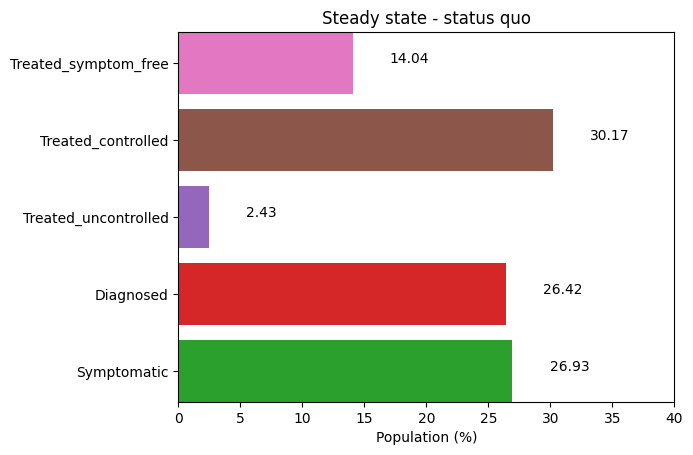

In [21]:
ax = plt.barh(list(aggstates_statusquo),aggstates_statusquo.values[0],color=['C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
for k, v, in enumerate(aggstates_statusquo.values[0]):
    plt.text(v + 3, k , f'{v:.2f}')
print((aggstates_statusquo.values[0]))
plt.xlabel('Population (%)')
plt.title('Steady state - status quo')
plt.margins(0,0)
plt.xlim([0,40])
plt.savefig("figures/01_steadystate.png", bbox_inches='tight', dpi=600)

In [ ]:
ax = plt.barh(list(aggstates_all1),aggstates_all1.values[0],color=['C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
for k, v, in enumerate(aggstates_all1.values[0]):
    plt.text(v + 3, k , f'{v:.2f}')
print((aggstates_all1.values[0]))
plt.xlabel('Population (%)')
plt.margins(0,0)
plt.xlim([0,50])
plt.title('Steady state - all interventions')
plt.savefig("figures/01_steadystate_allinterventions.png", bbox_inches='tight', dpi=600)

In [ ]:
plt.figure()
#(list(range(len(ind)))
#shareUCT=np.append(shareUCT,shareUCT)
labels=['Status quo', 'Awareness','Education', 'DMP', 'All interventions']
shareUCT=np.array([shareUCT_statusquo, shareUCT_awa1, shareUCT_edu1, shareUCT_dmp1, shareUCT_all1])
meanUCT=np.array([meanUCT_statusquo, meanUCT_awa1, meanUCT_edu1, meanUCT_dmp1, meanUCT_all1])

bar1 = plt.bar(labels,(100-shareUCT),.75, label = r'UCT $<$'+str(cutoff_highUCT))
bar2 = plt.bar(labels,(shareUCT),.75, bottom = (100-shareUCT), label = r'UCT $\geq$'+str(cutoff_highUCT))

for rect in bar1: 
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height/2, f'{height:.2f}', ha='center', va='bottom')
for rect in bar2: 
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, (100-height)+height/2, f'{height:.2f}', ha='center', va='bottom')
k=0
for rect in bar1:
    plt.text(rect.get_x() + rect.get_width() / 2.0, 101, r'$\O$ UCT' +f'\n' + f'{meanUCT[k]:.2f}', ha='center', va = 'bottom')
    k+=1

plt.ylim([0,115])
plt.legend(loc='lower left')
plt.savefig("figures/02_Interventions.png", bbox_inches='tight', dpi=600)


In [22]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m, m-h, m+h

In [ ]:
# get CI, std etc.

x0 = np.array([1,0,0,0,0,0,0,0,0]) 
timelength=525
n_patients=10000
result=np.zeros((timelength,n_patients))
result_awa1=result.copy()
result_edu1=result.copy()
result_dmp1=result.copy()
result_all1=result.copy()


for k in range(0,n_patients):
    #print(k)
    t=timeseries_MC_vec(transMatrix, x0, timelength, 1)
    t_awa1=timeseries_MC_vec(transMatrix_awa1, x0, timelength, 1) 
    t_edu1=timeseries_MC_vec(transMatrix_edu1, x0, timelength, 1)
    t_dmp1=timeseries_MC_vec(transMatrix_dmp1, x0, timelength, 1)    
    t_all1=timeseries_MC_vec(transMatrix_all1, x0, timelength, 1)
    result[:,k]=np.dot(t,UCTMatrix.T).reshape(timelength,)#[1,2,3,4,5,6,7,8,9])
    result_awa1[:,k]=np.dot(t_awa1,UCTMatrix.T).reshape(timelength,)#[1,2,3,4,5,6,7,8,9])
    result_edu1[:,k]=np.dot(t_edu1,UCTMatrix.T).reshape(timelength,)#[1,2,3,4,5,6,7,8,9])
    result_dmp1[:,k]=np.dot(t_dmp1,UCTMatrix.T).reshape(timelength,)#[1,2,3,4,5,6,7,8,9])
    result_all1[:,k]=np.dot(t_all1,UCTMatrix.T).reshape(timelength,)#[1,2,3,4,5,6,7,8,9])


mean, lower, upper = [],[],[]

mean_awa1, lower_awa1, upper_awa1 = [],[],[]
mean_edu1, lower_edu1, upper_edu1 = [],[],[]
mean_dmp1, lower_dmp1, upper_dmp1 = [],[],[]
mean_all1, lower_all1, upper_all1 = [],[],[]

ci = 0.95
for i in range (timelength):
    a = result[i,:] # this is the output
    a_awa1 = result_awa1[i,:]
    a_edu1 = result_edu1[i,:]
    a_dmp1 = result_dmp1[i,:]
    a_all1 = result_all1[i,:]
    m, ml, mu = mean_confidence_interval(a, ci)
    m_awa1, ml_awa1, mu_awa1 = mean_confidence_interval(a_awa1, ci)
    m_edu1, ml_edu1, mu_edu1 = mean_confidence_interval(a_edu1, ci)
    m_dmp1, ml_dmp1, mu_dmp1 = mean_confidence_interval(a_dmp1, ci)
    m_all1, ml_all1, mu_all1 = mean_confidence_interval(a_all1, ci)
    mean.append(m)
    lower.append(ml)
    upper.append(mu)
    mean_awa1.append(m_awa1)
    lower_awa1.append(ml_awa1)
    upper_awa1.append(mu_awa1)   
    mean_edu1.append(m_edu1)
    lower_edu1.append(ml_edu1)
    upper_edu1.append(mu_edu1)   
    mean_dmp1.append(m_dmp1)
    lower_dmp1.append(ml_dmp1)
    upper_dmp1.append(mu_dmp1)   
    mean_all1.append(m_all1)
    lower_all1.append(ml_all1)
    upper_all1.append(mu_all1)    

x_plot=np.linspace(0,timelength/52,timelength)
plt.figure()
plt.plot(x_plot,mean,'-b', label='Status quo')
plt.plot(x_plot,upper,'-k')
plt.plot(x_plot,lower,'-k')
# fill the area with black color, opacity 0.15
plt.fill_between(x_plot, upper, lower, color="k", alpha=0.15)

plt.plot(x_plot,mean_all1,'-r', label='All interventions')
plt.plot(x_plot,upper_all1,'-k')
plt.plot(x_plot,lower_all1,'-k')
# fill the area with black color, opacity 0.15
plt.fill_between(x_plot, upper_all1, lower_all1, color="k", alpha=0.15)

plt.xlim([0,(timelength-5)/52/2])
plt.xlabel("Time (years)")
plt.ylabel("Expected UCT Progression")
plt.ylim([5.9,13.5])
plt.legend()
plt.savefig("figures/03_UCT Evolution_5y.png", bbox_inches='tight', dpi=600)

plt.xlim([0,(timelength-5)/52])
plt.xlabel("Time (years)")
plt.ylabel("Expected UCT Progression")
plt.ylim([5.9,14.5])
plt.savefig("figures/03_UCT Evolution_10y.png", bbox_inches='tight', dpi=600)

## Export Data

In [ ]:
# Interventions
np.savetxt("UCT_progression_interventions.csv", [x_plot,mean, upper, lower, mean_awa1, mean_edu1, mean_dmp1, mean_all1, upper_all1, lower_all1], delimiter=",")

## Old

In [ ]:
# fit disease states
t=100
def model_diseasestates(variables):
    #u: uncontrolled;  c: controlled;  s: symptom-free
    uu = variables[0]
    uc = variables[1]
    us = variables[2]
    cu = variables[3]
    cc = variables[4]
    cs = variables[5]
    su = variables[6]
    sc = variables[7]
    ss = variables[8]    
    transMatrix=np.array([[uu, uc, us],
                         [cu, cc, cs],
                         [su, sc, ss]])
    transMatrix_norm=normalize(transMatrix, axis=1, norm='l1')
    #display(transMatrix_norm)


    initialState = np.array([0.614,0.3088,0.0772])   
    timeevol=initialState
    for k in range(1,t):
        timeevol=np.append(timeevol,np.matmul(initialState,matrix_power(transMatrix_norm, k)))
    timeevol=timeevol.reshape((k+1),len(initialState))
    return timeevol

def residual(variables):
    data=df_diseasestates_input[0:t]
    return (((data-model_diseasestates(variables))**2).sum().sum()) 

start_params=[.838,.0162,.00,.009,.904,.087,.009,.192,.799] 

#display(residual(variables))
out = least_squares(residual, start_params, bounds=(0,1))
plt.plot(model_diseasestates(out.x),'-')
plt.plot(df_diseasestates_input[0:t],'.')
diseaseprobabilities_fitted=normalize(out.x.reshape(3,3), axis=1, norm='l1')
display(diseaseprobabilities_fitted)

In [ ]:
# Time Evolution
def time_evolution(transMatrix,initialState):
    for k in range(len(transMatrix)):
        transMatrix[k,k]=0
        transMatrix[k,k]=1-sum(transMatrix[k,:])
      
    timeevol=initialState
    for k in range(1,500):
        timeevol=np.append(timeevol,np.matmul(initialState,matrix_power(transMatrix, k)))
    timeevol=timeevol.reshape((k+1),len(initialState))
    UCT_evol=sum(np.transpose(timeevol[:,0:9]*UCTMatrix[:,0:9]))
    transMatrix_ss=transMatrix.copy()
    transMatrix_ss[8,8]=0
    transMatrix_ss[8,0]=1
    #print(transMatrix_ss)
    steadystate=(np.matmul(initialState,matrix_power(transMatrix_ss, 1000)))
    UCT_ss=sum(sum(steadystate*UCTMatrix))
    return(steadystate, timeevol, UCT_evol, UCT_ss)

In [ ]:
# Monte Carlo
remission_prob=np.asarray(df_remission)

def timeseries_MC(transMatrix, x0, timelength,n_patients):
    n_states=x0.size
    result=np.zeros((timelength,n_states))
    nrem=0
    for l in range(0,n_patients):  
        x_k=x0.copy()
        result_l=np.zeros((timelength,n_states))
        result_l[0,]=x_k
        for k in range(1,timelength):
            if k<1000:
                transMatrix[0:8,8]=remission_prob[k]
                for m in range(len(transMatrix)):
                    transMatrix[m,m]=0
                    transMatrix[m,m]=1-sum(transMatrix[m,:])
            x_k=np.dot(x_k,transMatrix)
            a=np.random.choice(range(n_states), 1, p=x_k)
            x_k=np.zeros(n_states)
            x_k[a]=1
            #print(a)
            result_l[k,]=x_k
            if a==n_states-1:
                result_l[k+1:-1,]=x_k
                break
            if k==timelength-1:
                nrem+=1 #non remission
        result+=result_l
    #print(nrem)
    return result

In [ ]:
#display(transMatrix)
initialState = np.array([1,0,0,0,0,0,0,0,0]) 
steadystate,timeevol,UCT_evol, UCT_ss=time_evolution(transMatrix, initialState)
#header(UCT_evol)
display(UCT_ss)
#display(UCTMatrix[:,0:9])

In [ ]:
# variation
display(transMatrix)

variation_scale=np.array([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
variation_ratio=variation_scale
#variation_ratio=np.array([.1,.2,.3,1])
UCT_ss_var_diagtime=np.array([UCT_ss])
UCT_ss_var_treattime=np.array([UCT_ss])
for k in variation_scale: # Diagnosis time
    #print(k)
    transMatrix_var=transMatrix.copy()
    transMatrix_var[0,1]=transMatrix[0,1]*(1+k)  
    transMatrix_var[0,2]=transMatrix[0,2]*(1+k)
    #display(transMatrix_var[0,1])
    steadystate_var,timeevol_var,UCT_evol_temp, UCT_ss_temp=time_evolution(transMatrix_var,initialState)
    UCT_ss_var_diagtime=np.append(UCT_ss_var_diagtime,UCT_ss_temp)
UCT_evol_diagtime=UCT_evol_temp.copy()
    
for k in variation_scale: # Treatment time
    #print(k)
    transMatrix_var=transMatrix.copy()
    transMatrix_var[1,3]=transMatrix[1,3]*(1+k)  
    transMatrix_var[1,4]=transMatrix[1,4]*(1+k)
    #display(transMatrix_var[0,1])
    steadystate_var,timeevol_var,UCT_evol_temp, UCT_ss_temp=time_evolution(transMatrix_var,initialState)
    UCT_ss_var_treattime=np.append(UCT_ss_var_treattime,UCT_ss_temp)
UCT_evol_treattime=UCT_evol_temp.copy()

UCT_ss_var_diagrate=np.array([UCT_ss])
UCT_ss_var_treatrate=np.array([UCT_ss])

for k in variation_ratio: # Diagnosis ratio
    transMatrix_var=transMatrix.copy()
    transMatrix_var[0,1]=transMatrix[0,1]+transMatrix[0,2]*(k)  
    transMatrix_var[0,2]=transMatrix[0,2]-transMatrix[0,2]*(k)    
    steadystate_var,timeevol_var,UCT_evol_temp, UCT_ss_temp=time_evolution(transMatrix_var,initialState)
    UCT_ss_var_diagrate=np.append(UCT_ss_var_diagrate,UCT_ss_temp)    
UCT_evol_diagrate=UCT_evol_temp.copy()
    
for k in variation_ratio: # Treatment ratio
    transMatrix_var=transMatrix.copy()
    transMatrix_var[1,3]=transMatrix[1,3]+transMatrix[1,4]*(k)  
    transMatrix_var[1,4]=transMatrix[1,4]-transMatrix[1,4]*(k)    
    #print(transMatrix[1,3]+transMatrix[1,4]*(k))
    #print(transMatrix[1,4]-transMatrix[1,4]*(k))
    steadystate_var,timeevol_var,UCT_evol_temp, UCT_ss_temp=time_evolution(transMatrix_var,initialState)
    UCT_ss_var_treatrate=np.append(UCT_ss_var_treatrate,UCT_ss_temp) 
    #display(steadystate_var)
UCT_evol_treatrate=UCT_evol_temp.copy()
    
display(UCT_ss_var_diagtime) 
display(UCT_ss_var_treattime) 
display(UCT_ss_var_diagrate)
display(UCT_ss_var_treatrate)

    
    

In [ ]:
n_iter=2#1000
optim=np.zeros((10,n_iter))

steadystate_statusquo=get_steadystate(transMatrix)
steadystate_edu1=get_steadystate(transMatrix_edu1)
steadystate_awa1=get_steadystate(transMatrix_awa1)
steadystate_dmp1=get_steadystate(transMatrix_dmp1)
steadystate_all1=get_steadystate(transMatrix_all1)

[meanUCT_statusquo,shareUCT_statusquo,aggstates_statusquo]=reshape_steadystate_variables(steadystate_statusquo, states, UCTMatrix)
[meanUCT_edu1,shareUCT_edu1,aggstates_edu1]=reshape_steadystate_variables(steadystate_edu1, states, UCTMatrix)
[meanUCT_awa1,shareUCT_awa1,aggstates_awa1]=reshape_steadystate_variables(steadystate_awa1, states, UCTMatrix)
[meanUCT_dmp1,shareUCT_dmp1,aggstates_dmp1]=reshape_steadystate_variables(steadystate_dmp1, states, UCTMatrix)
[meanUCT_all1,shareUCT_all1,aggstates_all1]=reshape_steadystate_variables(steadystate_all1, states, UCTMatrix)

optim[0,0]=meanUCT_statusquo
optim[1,0]=meanUCT_awa1
optim[2,0]=meanUCT_edu1
optim[3,0]=meanUCT_dmp1
optim[4,0]=meanUCT_all1

optim[5,0]=shareUCT_statusquo
optim[6,0]=shareUCT_awa1
optim[7,0]=shareUCT_edu1
optim[8,0]=shareUCT_dmp1
optim[9,0]=shareUCT_all1


for k in range(1,n_iter):
    print(k)
    #plt.close()
    #steadystate_statusquo_k=get_steadystate(transMatrix)
    #steadystate_edu1_k=get_steadystate(transMatrix_edu1)
    #steadystate_awa1_k=get_steadystate(transMatrix_awa1)
    #steadystate_dmp1_k=get_steadystate(transMatrix_dmp1)
    #steadystate_all1_k=get_steadystate(transMatrix_all1)
    
    steadystate_statusquo+=get_steadystate(transMatrix)
    steadystate_awa1+=get_steadystate(transMatrix_awa1)    
    steadystate_edu1+=get_steadystate(transMatrix_edu1)
    steadystate_dmp1+=get_steadystate(transMatrix_dmp1)
    steadystate_all1+=get_steadystate(transMatrix_all1)
    
    [meanUCT_statusquo,shareUCT_statusquo,aggstates_statusquo]=reshape_steadystate_variables(steadystate_statusquo, states, UCTMatrix)
    [meanUCT_awa1,shareUCT_awa1,aggstates_awa1]=reshape_steadystate_variables(steadystate_awa1, states, UCTMatrix)
    [meanUCT_edu1,shareUCT_edu1,aggstates_edu1]=reshape_steadystate_variables(steadystate_edu1, states, UCTMatrix)
    [meanUCT_dmp1,shareUCT_dmp1,aggstates_dmp1]=reshape_steadystate_variables(steadystate_dmp1, states, UCTMatrix)
    [meanUCT_all1,shareUCT_all1,aggstates_all1]=reshape_steadystate_variables(steadystate_all1, states, UCTMatrix)
    
    optim[0,k]=meanUCT_statusquo/(k+1)
    optim[2,k]=meanUCT_edu1/(k+1)
    optim[1,k]=meanUCT_awa1/(k+1)
    optim[3,k]=meanUCT_dmp1/(k+1)
    optim[4,k]=meanUCT_all1/(k+1)

    optim[5,k]=shareUCT_statusquo/(k+1)
    optim[7,k]=shareUCT_edu1/(k+1)
    optim[6,k]=shareUCT_awa1/(k+1)
    optim[8,k]=shareUCT_dmp1/(k+1)
    optim[9,k]=shareUCT_all1/(k+1)

steadystate_statusquo/=(k+1)
steadystate_awa1/=(k+1)   
steadystate_edu1/=(k+1)
steadystate_dmp1/=(k+1)
steadystate_all1/=(k+1)   

[meanUCT_statusquo,shareUCT_statusquo,aggstates_statusquo]=reshape_steadystate_variables(steadystate_statusquo, states, UCTMatrix)
[meanUCT_edu1,shareUCT_edu1,aggstates_edu1]=reshape_steadystate_variables(steadystate_edu1, states, UCTMatrix)
[meanUCT_awa1,shareUCT_awa1,aggstates_awa1]=reshape_steadystate_variables(steadystate_awa1, states, UCTMatrix)
[meanUCT_dmp1,shareUCT_dmp1,aggstates_dmp1]=reshape_steadystate_variables(steadystate_dmp1, states, UCTMatrix)
[meanUCT_all1,shareUCT_all1,aggstates_all1]=reshape_steadystate_variables(steadystate_all1, states, UCTMatrix)

plt.plot(np.linspace(0,n_iter,n_iter),optim[5,],color='k')
plt.plot(np.linspace(0,n_iter,n_iter),optim[6,])
plt.plot(np.linspace(0,n_iter,n_iter),optim[7,])
plt.plot(np.linspace(0,n_iter,n_iter),optim[8,])
plt.plot(np.linspace(0,n_iter,n_iter),optim[9,])    

In [ ]:
# Interventions on steadystate
transMatrix_var=transMatrix.copy()
#display(transMatrix_var)
#UCT_ss_var_diagrate=np.array([UCT_ss])

transMatrix_var[0,1]=(transMatrix[0,1]+transMatrix[0,2])*2 
transMatrix_var[0,2]=transMatrix[0,2]-transMatrix[0,2]  
transMatrix_var[1,3]=(transMatrix[1,3]+transMatrix[1,4])*2  
transMatrix_var[1,4]=transMatrix[1,4]-transMatrix[1,4] 
transMatrix_var[8,8]=0
transMatrix_var[8,0]=1
steadystate_allinterventions,timeevol_allinterventions,UCT_evol_allinterventions, UCT_ss_allinterventions=time_evolution(transMatrix_var,steadystate)

display(timeevol_allinterventions)

### Plotting

In [ ]:
print(timeevol[499,:])

In [ ]:
# Plot
plot_stateorder=[0,1,2,3,4,5,6,7,8]
plt.plot(np.linspace(0,500/52,500),timeevol[:,plot_stateorder]*100, label=states[plot_stateorder])
#plt.yscale('log')
#plt.title('Population Evolution')
plt.xlabel("Time (years)")
plt.ylabel("Population (%)")
plt.legend(loc='lower left', ncol=2)
plt.margins(0,0)
plt.savefig("figures/01_Population Evolution.png", bbox_inches='tight', dpi=600)

In [ ]:
plot_stateorder=[0,1,2,3,4,5,6,7,8]
plt.plot(np.linspace(0,500/52,500),timeevol_allinterventions[:,plot_stateorder]*100, label=states[plot_stateorder])
plt.yscale('log')
#plt.title('Population Evolution')
plt.xlabel("Time (years)")
plt.ylabel("Population (%)")
plt.legend(loc='lower left', ncol=2)
plt.margins(0,0)

In [ ]:
plot_stateorder=[0,1,2,3,4,5,6,7,8]
plt.stackplot(np.linspace(0,500/52,500),np.transpose(timeevol[:,plot_stateorder])*100,labels=states[plot_stateorder])
plt.legend(loc='upper right', ncol=1)
plt.margins(0,0)
#plt.title('Expected State Evolution')
plt.xlabel("Time (years)")
plt.ylabel("Expected state (%)")
plt.savefig("figures/02_Expected State Evolution.png", bbox_inches='tight', dpi=600)

In [ ]:
#plt.plot(np.linspace(0,500/52,500),sum(np.transpose(timeevol[:,0:9]*UCTMatrix[:,0:9])), label='Status quo')
plt.plot(np.linspace(0,500/52,500),UCT_evol, label='Status quo')
plt.plot(np.linspace(0,500/52,500),UCT_evol_diagtime,linestyle='dashed', label='50% diagnosis time')
#plt.plot(np.linspace(0,500/52,500),UCT_evol_treattime,linestyle='dashed', label='50% treatment time')
#plt.plot(np.linspace(0,500/52,500),UCT_evol_diagrate,linestyle='dashed', label='All diagnosed')
#plt.plot(np.linspace(0,500/52,500),UCT_evol_treatrate,linestyle='dashed', label='All treated')
plt.legend(loc='lower right', ncol=1)
#print(sum(np.transpose(timeevol[:,0:2]*UCTMatrix[:,0:2])))
plt.margins(0,0)
#plt.title('Expected UCT Evolution')
plt.xlabel("Time (years)")
plt.ylabel("Expected UCT Progression")
#plt.xlim([0,5])
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim([6,7])
#plt.ylim([14.4,15])
plt.savefig("figures/03_Expected UCT Evolution.png", bbox_inches='tight', dpi=600)

In [ ]:
plot_stateorder=[0,1,2,3,4,5,6,7,8]
plt.barh(states[plot_stateorder],steadystate[plot_stateorder]*100,color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
#plt.title('Steady State')
plt.xlabel('Population (%)')
plt.margins(0,0)
plt.savefig("figures/04_Steady State.png", bbox_inches='tight', dpi=600)

In [ ]:
timeevol_df_allinterventions=pd.DataFrame((timeevol_allinterventions.reshape(500,9)*100),columns=states)
display(timeevol_df_allinterventions)

In [ ]:
#Aggregate stated
steadystate_df=pd.DataFrame((steadystate.reshape(1,9)*100),columns=states)
steadystate_df_aggregated=pd.DataFrame()
steadystate_df_aggregated['Symptomatic']=steadystate_df.Symptomatic+steadystate_df.No_diagnosis_virt+steadystate_df.Remission_virt
steadystate_df_aggregated['Diagnosed']=steadystate_df.Diagnosed+steadystate_df.No_treatment_virt
steadystate_df_aggregated['Treatment_start']=steadystate_df.Treatment_start
steadystate_df_aggregated['Treated_uncontrolled']=steadystate_df.Unconrtrolled
steadystate_df_aggregated['Treated_controlled']=steadystate_df.Controlled
steadystate_df_aggregated['Treated_symptom_free']=steadystate_df.Symptom_free
display(steadystate_df)
display(steadystate_df_aggregated)
#print(steadystate_clean.Symptomatic+steadystate_clean.Diagnosed)
#.transpose
timeevol_df_allinterventions=pd.DataFrame((timeevol_allinterventions.reshape(500,9)*100),columns=states)
timeevol_df_allinterventions_aggregated=pd.DataFrame()
timeevol_df_allinterventions_aggregated['Symptomatic']=timeevol_df_allinterventions.Symptomatic+timeevol_df_allinterventions.No_diagnosis_virt+timeevol_df_allinterventions.Remission_virt
timeevol_df_allinterventions_aggregated['Diagnosed']=timeevol_df_allinterventions.Diagnosed+timeevol_df_allinterventions.No_treatment_virt
timeevol_df_allinterventions_aggregated['Treatment_start']=timeevol_df_allinterventions.Treatment_start
timeevol_df_allinterventions_aggregated['Treated_uncontrolled']=timeevol_df_allinterventions.Unconrtrolled
timeevol_df_allinterventions_aggregated['Treated_controlled']=timeevol_df_allinterventions.Controlled
timeevol_df_allinterventions_aggregated['Treated_symptom_free']=timeevol_df_allinterventions.Symptom_free
display(timeevol_df_allinterventions_aggregated)


In [ ]:
#steadystate_df_aggregated.plot.barh()
#plt.barh(states,steadystate*100,color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
plt.barh(list(steadystate_df_aggregated),steadystate_df_aggregated.values[0],color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
print(states)
print((steadystate_df_aggregated.values[0]))
plt.xlabel('Population (%)')
plt.margins(0,0)
plt.savefig("figures/06_Steady State_aggregated.png", bbox_inches='tight', dpi=600)

In [ ]:
plt.barh(list(steadystate_df_aggregated),timeevol_df_allinterventions_aggregated.values[0,:],color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
print(states)
print((steadystate_df_aggregated.values[0]))
plt.xlim([0,50])
plt.xlabel('Population (%)')
plt.title('Without intervention')
plt.margins(0,0)
plt.savefig("figures/08_Steady State_aggregated_interventions_0.png", bbox_inches='tight', dpi=600)

fig,ax= plt.subplots()
plt.barh(list(steadystate_df_aggregated),timeevol_df_allinterventions_aggregated.values[53,:],color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
print(states)
print((steadystate_df_aggregated.values[0]))
plt.xlim([0,50])
plt.xlabel('Population (%)')
plt.title('1 year after intervention')
plt.margins(0,0)
plt.savefig("figures/08_Steady State_aggregated_interventions_1.png", bbox_inches='tight', dpi=600)

fig,ax= plt.subplots()
plt.barh(list(steadystate_df_aggregated),timeevol_df_allinterventions_aggregated.values[105,:],color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
print(states)
print((steadystate_df_aggregated.values[0]))
plt.xlim([0,50])
plt.xlabel('Population (%)')
plt.title('2 years after intervention')
plt.margins(0,0)
plt.savefig("figures/08_Steady State_aggregated_interventions_2.png", bbox_inches='tight', dpi=600)

fig,ax= plt.subplots()
plt.barh(list(steadystate_df_aggregated),timeevol_df_allinterventions_aggregated.values[261,:],color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
print(states)
print((steadystate_df_aggregated.values[0]))
plt.xlim([0,50])
plt.xlabel('Population (%)')
plt.title('5 years after intervention')
plt.margins(0,0)
plt.savefig("figures/08_Steady State_aggregated_interventions_3.png", bbox_inches='tight', dpi=600)

In [ ]:
fig, ax= plt.subplots()
x_labels=list(timeevol_df_allinterventions_aggregated)
width = 0.22
ax.barh(np.arange(6),timeevol_df_allinterventions_aggregated.values[0,:],.2,color='#000080', label='without intervention')
ax.barh(np.arange(6)+width,timeevol_df_allinterventions_aggregated.values[53,:],.2,color='#0F52BA', label='1 year after intervention')
ax.barh(np.arange(6)+ (2*width),timeevol_df_allinterventions_aggregated.values[105,:],.2,color='#6593F5', label='2 years after intervention')
ax.barh(np.arange(6)+ (3*width),timeevol_df_allinterventions_aggregated.values[261,:],.2,color='#73C2FB', label='5 years after intervention')
ax.set_yticks(np.arange(6) + .5)
ax.set_yticklabels(x_labels)
ax.legend()
fig.tight_layout()
plt.margins(0,0)
plt.savefig("figures/07_Steady State_aggregated_interventions.png", bbox_inches='tight', dpi=600)

In [ ]:
plt.plot(np.linspace(0,100,11),UCT_ss_var_diagtime, label='Diagnosis Time')
plt.plot(np.linspace(0,100,11),UCT_ss_var_treattime, label='Time to Treatment')
plt.plot(np.linspace(0,100,11),UCT_ss_var_diagrate, label='Diagnosis Share')
plt.plot(np.linspace(0,100,11),UCT_ss_var_treatrate, label='Treatment Share')
plt.legend()
plt.xlabel('Variation (%)')
plt.ylabel('Mean UCT in Steady State')
plt.margins(0.0)
plt.savefig("figures/05_Steady State_interventions.png", bbox_inches='tight', dpi=600)


In [ ]:
np.savetxt("UCT_diagtime.csv", UCT_ss_var_diagtime, delimiter=",")
np.savetxt("UCT_timetotreat.csv", UCT_ss_var_treattime, delimiter=",")
np.savetxt("UCT_diagshare.csv", UCT_ss_var_diagrate, delimiter=",")
np.savetxt("UCT_treatshare.csv", UCT_ss_var_treatrate, delimiter=",")
print(timeevol[-1,[1,2,2]])